<div align="right"><a href="http://norvig.com">Peter Norvig</a><br><a href="https://github.com/norvig/pytudes">pytudes</a><br>March 2019</div>

# Dice Baseball

The [538 Riddler for March 22, 2019](https://fivethirtyeight.com/features/can-you-turn-americas-pastime-into-a-game-of-yahtzee/) asks us to simulate baseball using probabilities from a 19th century dice game called *Our National Ball Game*.:

    1,1: double         2,2: strike    3,3: out at 1st  4,4: fly out
    1,2: single         2,3: strike    3,4: out at 1st  4,5: fly out
    1,3: single         2,4: strike    3,5: out at 1st  4,6: fly out
    1,4: single         2,5: strike    3,6: out at 1st  5,5: double play
    1,5: base on error  2,6: foul out                   5,6: triple
    1,6: base on balls                                  6,6: home run


The rules left some things unspecified; the following are my current choices (in an early version I made different choices that resulted in slightly more runs):

* On a*&nbsp;b*-base hit, runners advance*&nbsp;b* bases, except that a runner on second scores on a 1-base hit.
* On an "out at first", all runners advance one base.
* A double play only applies if there is a runner on first; in that case other runners advance.
* On a fly out, a runner on third scores; other runners do not advance.
* On an error all runners advance one base. 
* On a base on balls, only forced runners advance.

I also made some choices about the implementation:

- Exactly one outcome happens to each batter. We call that an *event*.
- I'll represent events with the following one letter codes:
  - `K`, `O`, `o`, `f`, `D`: strikeout, foul out, out at first, fly out, double play
  - `1`, `2`, `3`, `4`: single, double, triple, home run
  - `E`, `B`: error, base on balls
- Note the "strike" dice roll is not an event; it is only part of an event. From the probability of a "strike" dice roll, I compute the probability of three strikes in a row, and call that a strikeout event. Sice there are 7 dice rolls giving "strike", the probability of a strike is 7/36, and the probability of a strikeout is (7/36)**3.
- Note that a die roll such as `1,1` is a 1/36 event, whereas `1,2` is a 2/36 event, because it also represents (2, 1).
- I'll keep track of runners with a list of occupied bases; `runners = [1, 2]` means runners on first and second.
- A runner who advances to base 4 or higher has scored a run (unless there are already 3 outs).
- The function `inning` simulates a half inning and returns the number of runs scored.
- I want to be able to test `inning` by feeding it specific events, and I also want to generate random innings. So I'll make the interface be that I pass in an *iterable* of events. The function `event_stream` generates an endless stream of randomly sampled events.
- I'll play 1 million innings and store the resulting scores in `innings`.
- To simulate a game I just sample 9 elements of `innings` and sum them.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [2]:
def event_stream(events='2111111EEBBOOooooooofffffD334', strike=7/36):
    "An iterator of random events. Defaults from `Our National Ball Game`."
    while True:
        yield 'K' if (random.random() < strike ** 3) else random.choice(events)
        
def inning(events=event_stream(), verbose=False) -> int:
    "Simulate a half inning based on events, and return number of runs scored."
    outs = runs = 0 # Inning starts with no outs and no runs,
    runners = []    # ... and with nobody on base
    for e in iter(events):
        if verbose: print(f'{outs} outs, {runs} runs, event: {e}, runners: {runners}')
        if e in 'KOofD':
            outs += 1         # Batter is out
        else:
            runners.append(0) # Batter becomes a runner
        # See what happens to runners:
        if e == 'D' and 1 in runners: # double play: runner on first is out
            outs += 1
            runners = [r + 1 for r in runners if r != 1]
        elif e in 'oE': # out at first or error: runners advance
            runners = [r + 1 for r in runners]
        elif e == 'f' and 3 in runners and outs < 3: # fly out: runner on 3rd scores
            runners.remove(3)
            runs += 1
        elif e in '1234': # single, double, triple, homer
            runners = [r + int(e) + (r == 2) for r in runners]
        elif e == 'B': # base on balls; forced runners advance one base
            runners = [r + forced(runners, r) for r in runners]
        # See if inning is over, and if not, whether anyone scored:
        if outs >= 3:
            return runs
        runs += sum(r >= 4 for r in runners)
        runners = [r for r in runners if r < 4]
        
def forced(runners, r) -> bool: return all(b in runners for b in range(r))

# Testing

Let's peek at some random innings:

In [3]:
inning(verbose=True)

0 outs, 0 runs, event: 2, runners: []
0 outs, 0 runs, event: 1, runners: [2]
0 outs, 1 runs, event: B, runners: [1]
0 outs, 1 runs, event: 4, runners: [2, 1]
0 outs, 4 runs, event: 3, runners: []
0 outs, 4 runs, event: E, runners: [3]
0 outs, 5 runs, event: f, runners: [1]
1 outs, 5 runs, event: o, runners: [1]
2 outs, 5 runs, event: 1, runners: [2]
2 outs, 6 runs, event: o, runners: [1]


6

In [4]:
inning(verbose=True)

0 outs, 0 runs, event: O, runners: []
1 outs, 0 runs, event: 1, runners: []
1 outs, 0 runs, event: 1, runners: [1]
1 outs, 0 runs, event: f, runners: [2, 1]
2 outs, 0 runs, event: 4, runners: [2, 1]
2 outs, 3 runs, event: O, runners: []


3

And we can feed in any events we want to test the code:

In [5]:
inning('2EBB1DB12f', verbose=True)

0 outs, 0 runs, event: 2, runners: []
0 outs, 0 runs, event: E, runners: [2]
0 outs, 0 runs, event: B, runners: [3, 1]
0 outs, 0 runs, event: B, runners: [3, 2, 1]
0 outs, 1 runs, event: 1, runners: [3, 2, 1]
0 outs, 3 runs, event: D, runners: [2, 1]
2 outs, 3 runs, event: B, runners: [3]
2 outs, 3 runs, event: 1, runners: [3, 1]
2 outs, 4 runs, event: 2, runners: [2, 1]
2 outs, 5 runs, event: f, runners: [3, 2]


5

That looks good.

# Simulating

Now, simulate a million innings, and then sample from them to simulate a million nine-inning games:

In [6]:
N = 1000000
innings = [inning() for _ in range(N)]
games = [sum(random.sample(innings, 9)) for _ in range(N)]

Finally, display the mean number of runs scored per team per nine-inning game, along with a histogram:

14.496243

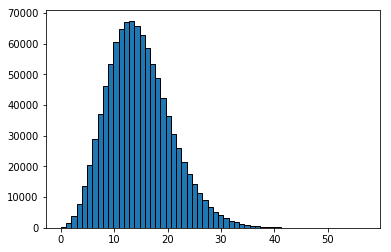

In [7]:
plt.hist(games, ec='black', bins=max(games)-min(games)+1)
sum(games) / N